In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import xgboost as xgb
import utils as ut
import pandas as pd


In [18]:
df = pd.read_csv('./data/train.csv')
df.index = df['Unnamed: 0']
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [19]:
# Разделяем датасет на X, y
X, y = ut.split_to_x_y(df, 'y')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [20]:
def fit_predict(model, eval_data):
    try:
        model = model(n_jobs=-1)
    except TypeError:
        model = model(random_state=42)
    finally:
        X_train = eval_data['X_train'] if type(eval_data['X_train']) == np.ndarray else eval_data['X_train'].values
        y_train = eval_data['y_train'] if type(eval_data['y_train']) == np.ndarray else eval_data['y_train'].values
        X_test = eval_data['X_test'] if type(eval_data['X_test']) == np.ndarray else eval_data['X_test'].values

        model.fit(X_train, y_train.ravel())
        pred = model.predict(X_test)
        return model, pred

In [21]:
eval_data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
models = [LogisticRegression, KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier]
max_evals = len(models)
metric = roc_auc_score  # f1_score, roc_auc_score, accuracy_score
metrics = []
fitted_models = []

for model in models:
    model_fitted, pred = fit_predict(model, eval_data)

    metrics.append(metric(eval_data['y_test'].values.ravel(), pred))
    fitted_models.append(model_fitted)

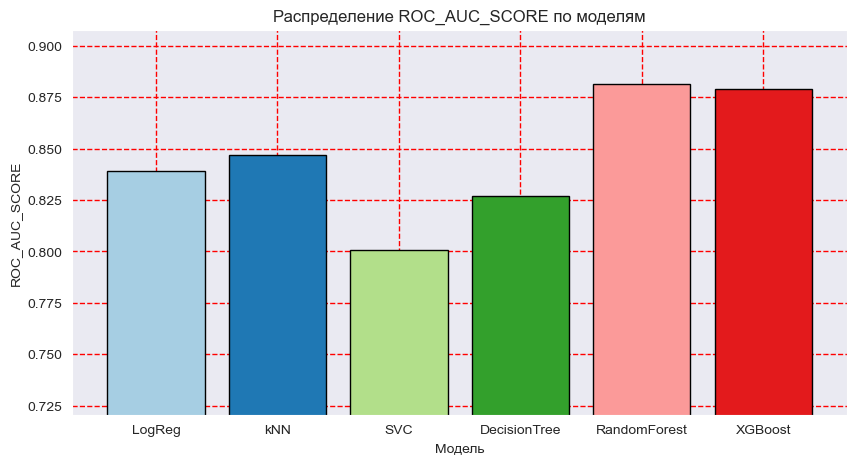

In [22]:
models_names = ['LogReg', 'kNN', 'SVC', 'DecisionTree', 'RandomForest', 'XGBoost']
ut.plot_metrics_hist(models_names, metrics)

In [23]:
best_metric = max(metrics)
best_model_name = models_names[metrics.index(best_metric)]
best_model = fitted_models[metrics.index(best_metric)]

print('Best Model:', best_model_name)
print('Best Metric, ROC_AUC_SCORE:', round(best_metric, 4))
print(classification_report(y_true=y_test, y_pred=best_model.predict(X_test.values)))

Best Model: RandomForest
Best Metric, ROC_AUC_SCORE: 0.8814
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88       719
         1.0       0.86      0.92      0.89       736

    accuracy                           0.88      1455
   macro avg       0.88      0.88      0.88      1455
weighted avg       0.88      0.88      0.88      1455



In [24]:
import joblib

# Сохранение модели в файл
filename = 'model.pkl'
joblib.dump(best_model, filename)

['model.pkl']